In [21]:
import cv2
from noise import noisy
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output, display
from pytorch_msssim import ssim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [47]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rajat95gupta/smartphone-image-denoising-dataset")
path = path + "/SIDD_Small_sRGB_Only" + "/Data"

print("Path to image files:", path)

Path to image files: /Users/frankolas/.cache/kagglehub/datasets/rajat95gupta/smartphone-image-denoising-dataset/versions/1/SIDD_Small_sRGB_Only/Data


In [3]:
def create_dataset():
  data = []
  for filename in os.listdir(path):
    gt_path = None
    noisy_path = None
    for f in os.listdir(os.path.join(path, filename)):
        if f.startswith('GT_'):
            gt_path = os.path.join(path,filename, f)

        elif f.startswith('NOISY_'):
            noisy_path = os.path.join(path, filename, f)

    data.append({'gt':gt_path, 'noisy':noisy_path})

  return data

Path to image files: Deep-Learning-Data
Path to noisy image files Deep-Learning-Data-


In [23]:
if torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print('using device:', device)

using device: mps


In [45]:
path = "Deep-Learning-Data"
noisy_path = "Deep-Learning-Data-"
print("Path to image files:", path)
print("Path to noisy image files", noisy_path)

def create_dataset(noise_type):
  data = []
  full_noisy_path = noisy_path + noise_type
  noisy_path_dir = os.listdir(full_noisy_path)
  for filename in os.listdir(path):
    filepath = os.path.join(path, filename)
    noisy_filepath = os.path.join(full_noisy_path, filename)
    if (filename in noisy_path_dir): # checking so we don't make copies of the same image
      data.append({"gt": filepath, "noisy": noisy_filepath})
    else:
      img = cv2.imread(filepath)
      cv2.imwrite(full_noisy_path, noisy(str.lower(noise_type), img))
      data.append({"gt": filepath, "noisy": noisy_filepath})
  return data

Path to image files: Deep-Learning-Data
Path to noisy image files Deep-Learning-Data-


In [46]:
image_data = create_dataset("Gauss")
print(image_data[2])

{'gt': 'Deep-Learning-Data/image_414.jpeg', 'noisy': 'Deep-Learning-Data-Gauss/image_414.jpeg'}


In [47]:
from PIL import Image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        gt_path = self.data[idx]['gt']
        noisy_path = self.data[idx]['noisy']
        gt = Image.open(gt_path)
        noisy = Image.open(noisy_path)
        if self.transform:
            gt = self.transform(gt)
            noisy = self.transform(noisy)
        return gt, noisy


In [55]:
NUM_TRAIN = 144

data = create_dataset("poisson")

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

train = CustomImageDataset(data, transform=transform)
loader_train = DataLoader(train, batch_size=batch_size,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomImageDataset(data, transform=transform)
loader_val = DataLoader(val, batch_size=batch_size,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 160)))

test = CustomImageDataset(data, transform=transform)
loader_test = DataLoader(test, batch_size=batch_size)

Show sample images from training set

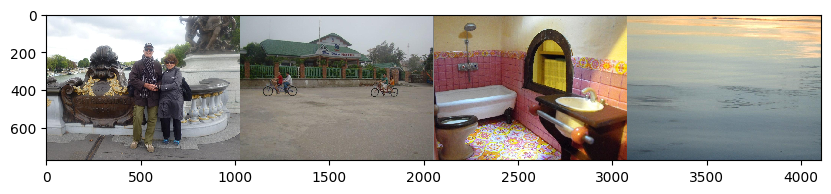

In [56]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(loader_train)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [57]:
def flatten(x, start_dim=1, end_dim=-1):
  return x.view(-1)

In [58]:
dtype = torch.float
ltype = torch.long

def check_accuracy(loader, model):
    if hasattr(loader.dataset, 'train') and loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')

    num_correct = 0
    num_samples = 0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # Move inputs to device
            y = y.to(device=device, dtype=ltype)  # Ensure y is integer type for classification

            # Process y if it is one-hot encoded or has extra dimensions
            if len(y.shape) > 1:
                y = y.argmax(dim=1)  # Convert one-hot encoded y to class indices

            scores = model(x)  # Forward pass
            _, preds = scores.max(1)  # Get predicted class (index of max score)

            # Print debug info
            # print(f"Preds shape: {preds.shape}, y shape: {y.shape}")
            
            preds = flatten(preds)
            y = flatten(y)

            # print(f"Preds shap after flatteninge: {preds.shape}," + 
            #       f"y shape after flattening: {y.shape}")
            
            # Compare predictions with ground truth
            num_correct += (preds == y).sum().item()  # Count correct predictions
            num_samples += preds.size(0)  # Update total samples
        
        acc = float(num_correct) / num_samples  # Calculate accuracy
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc

In [66]:
# Constant to control how frequently we print train loss
print_every = 5
mse_loss_fn = nn.MSELoss()

def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd
      
def compute_snr(scores, y):
  signal_pow = torch.sum(y ** 2)
  noise_power = torch.sum((scores + y) ** 2)
  
  snr = 10 * torch.log10(signal_pow / noise_power)
  
  return snr

def train(model, optimizer, epochs=5, learning_rate_decay=.1, alpha=0.5, beta=0.5, gamma=0.001, schedule=[], verbose=True):
  """
  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for

  Returns: Accuracy History, also prints model accuracies during training.
  """
  above_99 = 0
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  num_iters = epochs * len(loader_train)
  if verbose:
    num_prints = num_iters // print_every + 1
  else:
    num_prints = epochs
  acc_history = torch.zeros(num_prints, dtype=torch.float)
  iter_history = torch.zeros(num_prints, dtype=torch.long)

  for e in range(epochs):

    adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)

    for t, (x, y) in enumerate(loader_train):
      model.train()  # put model to training modeq
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=dtype)

      scores = model(x)
      # print(f"Shape of scores: {scores.shape}, dtype: {scores.dtype}")
      # print(f"Shape of y:{y.shape}, dtype: {y.dtype}")

      snr_loss = -compute_snr(scores, y)
      mse_loss = mse_loss_fn(scores, y)
      ssim_loss = ssim(scores, y, data_range=1.0)
      loss = alpha * mse_loss + beta * (1 - ssim_loss) + gamma * snr_loss

      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # This is the backwards pass: compute the gradient of the loss with
      # respect to each  parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients
      # computed by the backwards pass.
      optimizer.step()

      tt = t + e * len(loader_train)

      if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader_train)-1)):
        print('Epoch %d, Iteration %d, loss = %.4f, mse loss = %.4f, ssim_loss = %.4f, snr loss = %.4f' % (e, tt, loss.item(), mse_loss, ssim_loss, snr_loss))
        acc = check_accuracy(loader_val, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        print()
      elif not verbose and (t == len(loader_train)-1):
        print('Epoch %d, Iteration %d, loss = %.4f, mse loss = %.4f, ssim_loss = %.4f, snr loss = %.4f' % (e, tt, loss.item(), mse_loss, ssim_loss, snr_loss))
        acc = check_accuracy(loader_val, model)
        acc_history[e] = acc
        iter_history[e] = tt
        print()
      if (acc > 0.99): above_99 += 1
      if (above_99 >= 5): return acc_history, iter_history
  return acc_history, iter_history

Denoinsing Model

In [67]:
from typing import OrderedDict

class Flatten(nn.Module):
  def forward(self, x):
    return flatten(x)

C, H, W = 3, 1024, 768
num_classes = 10

channel_1 = 32
channel_2 = 64
channel_3 = 128
channel_4 = 256

pool_size = nn.MaxPool2d(2)

kernel_size_1 = 3
pad_size_1 = 1
kernel_size_2 = 3
pad_size_2 = 1
kernel_size_3 = 2
pad_size_3 = 1
kernel_size_4 = 1
pad_size_4 = 0


learning_rate = 4e-3
weight_decay = 1e-3
momentum = 0.9

model = None
optimizer = None

model = nn.Sequential(OrderedDict([
    ('conv1', nn.Conv2d(C, channel_1, kernel_size=kernel_size_1, padding=pad_size_1)),
    ('relu', nn.ReLU()),
    ('drop1', nn.Dropout(p=0.4)),
    
    ('conv2', nn.Conv2d(channel_1, channel_2, kernel_size=kernel_size_2, padding=pad_size_2)),
    ('relu', nn.ReLU()),
    
    ('conv3', nn.Conv2d(channel_2, channel_3, kernel_size=kernel_size_3, padding=pad_size_3)),
    ('relu', nn.ReLU()),
    ('drop2', nn.Dropout(p=0.3)),
   
    
    ('deconv3', nn.ConvTranspose2d(channel_3, channel_2, kernel_size=kernel_size_3, padding=pad_size_3)),
    ('relu', nn.ReLU()),
    
    ('deconv2', nn.ConvTranspose2d(channel_2, channel_1, kernel_size=kernel_size_2, padding=pad_size_2)),
    ('relu', nn.ReLU()),
    
    ('deconv1', nn.ConvTranspose2d(channel_1, C, kernel_size=kernel_size_1, padding=pad_size_1))
]))

model.to(device=device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay,
                      momentum=momentum, nesterov=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)

print('Architecture:')
print(model) # printing `nn.Module` shows the architecture of the module.
"""
dummy_input = torch.randn(1,3,32,32).to(device='mps')
x = dummy_input

for name, layer in model.named_children():
    x = layer(x)
    print(f"After layer {name}: {x.shape}")
"""
# END OF YOUR CODE

# You should get at least 70% accuracy
acc_history, iter_history = train(model, optimizer)

Architecture:
Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (drop1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (drop2): Dropout(p=0.3, inplace=False)
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv1): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Epoch 0, Iteration 0, loss = 0.6209, mse loss = 0.2411, ssim_loss = 0.0024, snr loss = 1.5877
Checking accuracy on test set
Got 519750 / 12582912 correct (4.13%)

Epoch 0, Iteration 5, loss = 0.6043, mse loss = 0.2303, ssim_loss = 0.0260, snr loss = 2.1135
Checking accuracy on test set
Got 2736971 / 12582912 correct (21.75%)

Epoch 0, Iteration 10, loss = 0.4850, mse loss = 0

In [135]:
for i in range(0,acc_history.shape[0]-1):
    print(f"iter {iter_history[i] + 1}: {(acc_history[i] * 100):.2f}%")
    
acc_history.shape

iter 1: 42.55%
iter 11: 82.14%
iter 21: 66.20%
iter 31: 58.55%
iter 41: 65.65%
iter 51: 59.38%
iter 61: 61.48%
iter 71: 66.81%
iter 81: 59.98%
iter 91: 51.87%
iter 101: 62.74%
iter 111: 54.98%


torch.Size([13])

In [ ]:
# Test the model
dummy_input = torch.randn(4, 3, 400, 400)  # Batch size 4, RGB channels, 400x400
device = torch.device("mps")
model.to(device)
dummy_input = dummy_input.to(device)

with torch.no_grad():
    output = model(dummy_input)

print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([4, 3, 400, 400])
Output shape: torch.Size([4, 3, 400, 400])
